Copyright (c) 2019 [Sebastian Raschka](sebastianraschka.com)

https://github.com/rasbt/python-machine-learning-book-3rd-edition

[MIT License](https://github.com/rasbt/python-machine-learning-book-3rd-edition/blob/master/LICENSE.txt)

# Rozdział 17. Generatywne sieci przeciwstawne w zadaniach syntetyzowania nowych danych (1/2)

Zwróć uwagę, że rozszerzenie zawierające nieobowiązkowy znak wodny stanowi niewielki plugin notatnika IPython / Jupyter, który zaprojektowałem w celu powielania kodu źródłowego. Wystarczy pominąć poniższe wiersze kodu:

In [1]:
%load_ext watermark
%watermark -a "Sebastian Raschka & Vahid Mirjalili" -u -d -p numpy,scipy,matplotlib,tensorflow,tensorflow_datasets

Sebastian Raschka & Vahid Mirjalili 
last updated: 2019-11-25 

numpy 1.17.2
scipy 1.2.1
matplotlib 3.1.0
tensorflow 2.0.0
tensorflow_datasets 1.3.0


In [2]:
from IPython.display import Image
%matplotlib inline

# Wprowadzenie do generatywnych sieci przeciwstawnych

## Autokodery

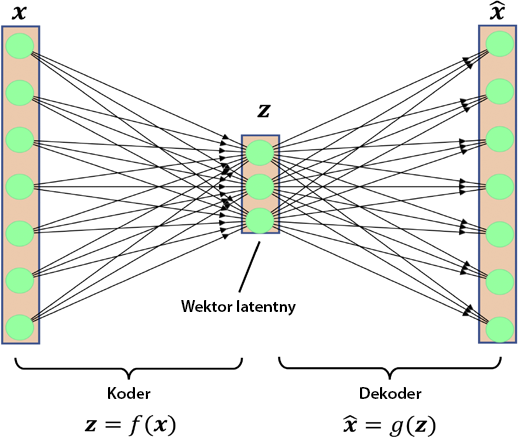

In [3]:
Image(filename='rysunki/17_01.png', width=500)

## Modele generatywne syntetyzujące nowe dane

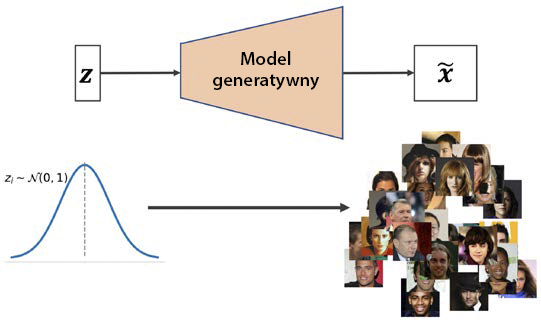

In [4]:
Image(filename='rysunki/17_02.png', width=700)

## Generowanie nowych prób za pomocą sieci GAN

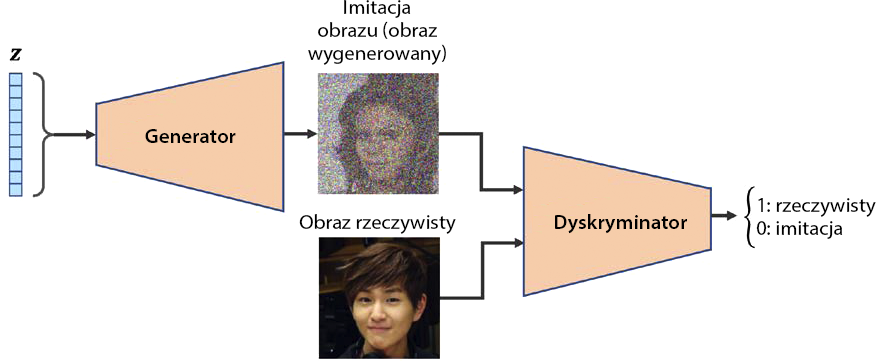

In [5]:
Image(filename='rysunki/17_03.png', width=700)

## Funkcje straty generatora i dyskryminatora w modelu GAN

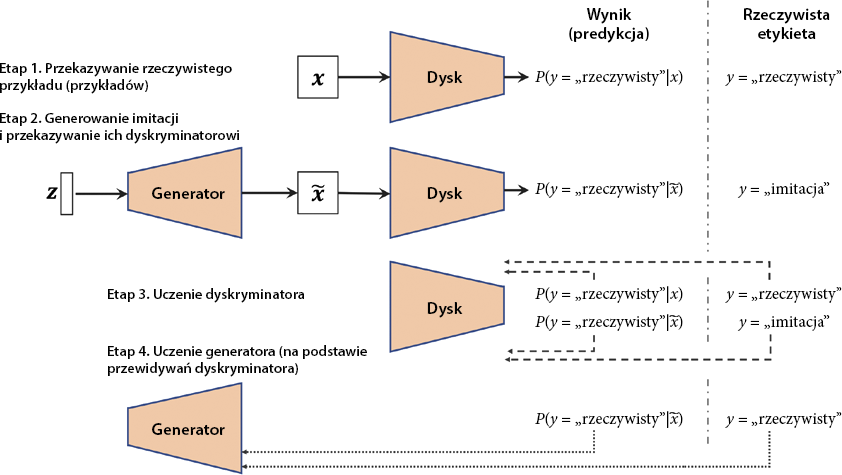

In [6]:
Image(filename='rysunki/17_04.png', width=800)

# Implementowanie sieci GAN od podstaw


## Uczenie modeli GAN w środowisku Google Colab

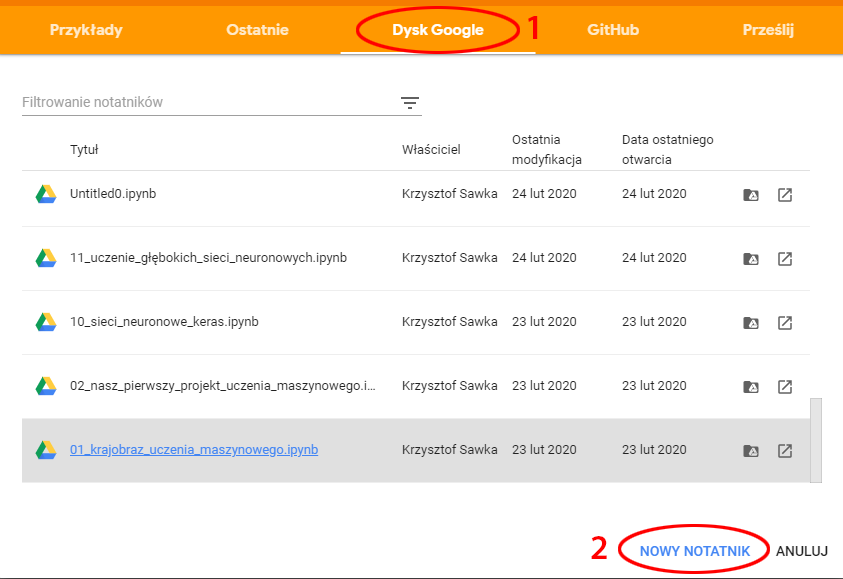

In [7]:
Image(filename='rysunki/17_05.png', width=700)

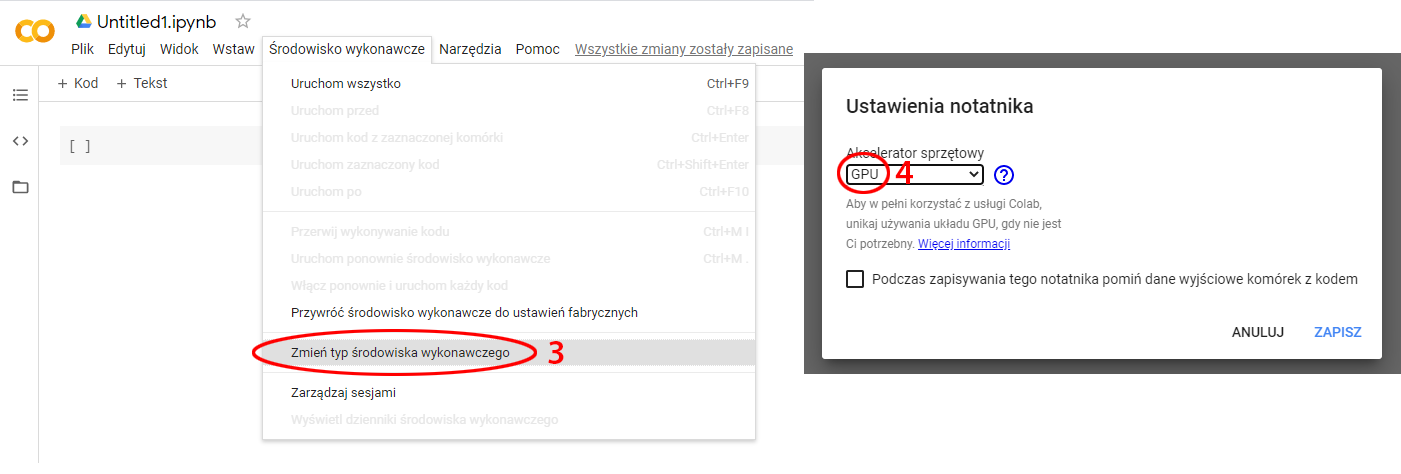

In [8]:
Image(filename='rysunki/17_06.png', width=600)

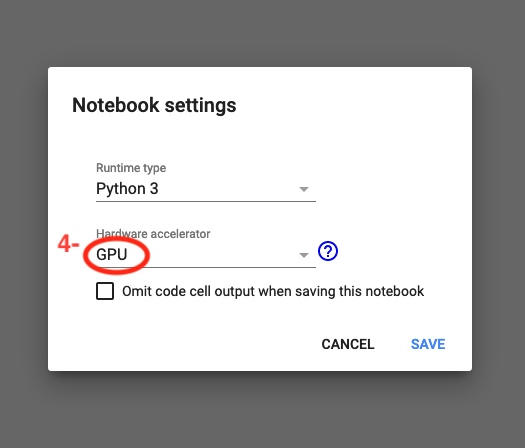

In [9]:
Image(filename='rysunki/17_07.png', width=600)

In [10]:
# Usuń znak komentarza z poniższego wiersza, jeżeli przetwarzasz ten notatnik w serwisie Google Colab
#! pip install -q tensorflow-gpu==2.3.0

In [11]:
import tensorflow as tf
print(tf.__version__)

print("Jednostka GPU dostępna:", tf.test.is_gpu_available())

if tf.test.is_gpu_available():
    device_name = tf.test.gpu_device_name()

else:
    device_name = 'cpu:0'
    
print(device_name)

2.0.0
GPU Available: True
/device:GPU:0


In [12]:
#from google.colab import drive
#drive.mount('/content/drive/')

## Implementacja sieci generatora i dyskryminatora

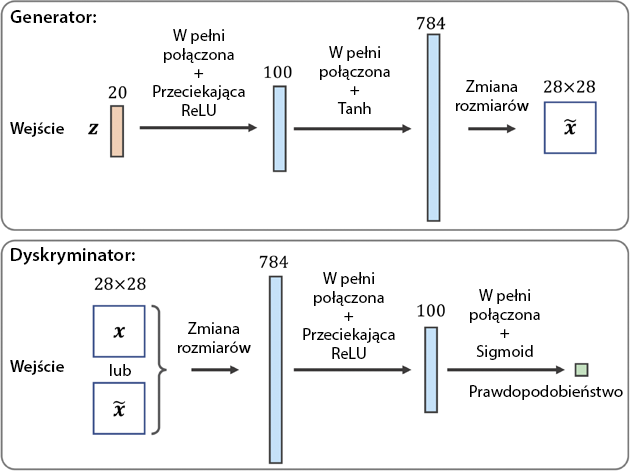

In [10]:
Image(filename='rysunki/17_08.png', width=600)

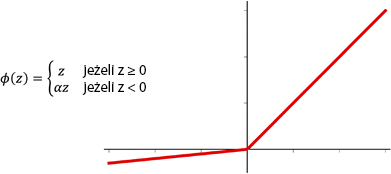

In [11]:
Image(filename='rysunki/17_17.png', width=600)

In [14]:
import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [15]:
## definiuje funkcję dla generatora:
def make_generator_network(
        num_hidden_layers=1,
        num_hidden_units=100,
        num_output_units=784):
    model = tf.keras.Sequential()
    for i in range(num_hidden_layers):
        model.add(
            tf.keras.layers.Dense(
                units=num_hidden_units, 
                use_bias=False)
            )
        model.add(tf.keras.layers.LeakyReLU())
        
    model.add(tf.keras.layers.Dense(
        units=num_output_units, activation='tanh'))
    return model

## definiuje funkcję dla dyskryminatora:
def make_discriminator_network(
        num_hidden_layers=1,
        num_hidden_units=100,
        num_output_units=1):
    model = tf.keras.Sequential()
    for i in range(num_hidden_layers):
        model.add(tf.keras.layers.Dense(units=num_hidden_units))
        model.add(tf.keras.layers.LeakyReLU())
        model.add(tf.keras.layers.Dropout(rate=0.5))
        
    model.add(
        tf.keras.layers.Dense(
            units=num_output_units, 
            activation=None)
        )
    return model

In [16]:
image_size = (28, 28)
z_size = 20
mode_z = 'uniform'  # 'uniform' a 'normal'
gen_hidden_layers = 1
gen_hidden_size = 100
disc_hidden_layers = 1
disc_hidden_size = 100

tf.random.set_seed(1)

gen_model = make_generator_network(
    num_hidden_layers=gen_hidden_layers, 
    num_hidden_units=gen_hidden_size,
    num_output_units=np.prod(image_size))

gen_model.build(input_shape=(None, z_size))
gen_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                multiple                  2000      
_________________________________________________________________
leaky_re_lu (LeakyReLU)      multiple                  0         
_________________________________________________________________
dense_1 (Dense)              multiple                  79184     
Total params: 81,184
Trainable params: 81,184
Non-trainable params: 0
_________________________________________________________________


In [17]:
disc_model = make_discriminator_network(
    num_hidden_layers=disc_hidden_layers,
    num_hidden_units=disc_hidden_size)

disc_model.build(input_shape=(None, np.prod(image_size)))
disc_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              multiple                  78500     
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    multiple                  0         
_________________________________________________________________
dropout (Dropout)            multiple                  0         
_________________________________________________________________
dense_3 (Dense)              multiple                  101       
Total params: 78,601
Trainable params: 78,601
Non-trainable params: 0
_________________________________________________________________


## Definiowanie zestawu danych uczących

In [18]:
mnist_bldr = tfds.builder('mnist')
mnist_bldr.download_and_prepare()
mnist = mnist_bldr.as_dataset(shuffle_files=False)

def preprocess(ex, mode='uniform'):
    image = ex['image']
    image = tf.image.convert_image_dtype(image, tf.float32)
    image = tf.reshape(image, [-1])
    image = image*2 - 1.0
    if mode == 'uniform':
        input_z = tf.random.uniform(
            shape=(z_size,), minval=-1.0, maxval=1.0)
    elif mode == 'normal':
        input_z = tf.random.normal(shape=(z_size,))
    return input_z, image



mnist_trainset = mnist['train']

print('Przed przetwarzaniem wstępnym:  ')
example = next(iter(mnist_trainset))['image']
print('dtype: ', example.dtype, ' Min: {} Max: {}'.format(np.min(example), np.max(example)))

mnist_trainset = mnist_trainset.map(preprocess)

print('Po przetwarzaniu wstępnym:  ')
example = next(iter(mnist_trainset))[0]
print('dtype: ', example.dtype, ' Min: {} Max: {}'.format(np.min(example), np.max(example)))

Before preprocessing:  
dtype:  <dtype: 'uint8'>  Min: 0 Max: 255
After preprocessing:  
dtype:  <dtype: 'float32'>  Min: -0.6264450550079346 Max: 0.9958574771881104


 * **Szczegółowy opis przepływu informacji**

In [19]:
mnist_trainset = mnist_trainset.batch(32, drop_remainder=True)
input_z, input_real = next(iter(mnist_trainset))
print('input-z -- rozmiar:', input_z.shape)
print('input-real -- rozmiar:', input_real.shape)

g_output = gen_model(input_z)
print('Wynik generatora -- rozmiar:', g_output.shape)

d_logits_real = disc_model(input_real)
d_logits_fake = disc_model(g_output)
print('Dyskryminator (rzeczywiste) -- rozmiar:', d_logits_real.shape)
print('Dyskryminator (imitacje) -- rozmiar:', d_logits_fake.shape)

input-z -- shape: (32, 20)
input-real -- shape: (32, 784)
Output of G -- shape: (32, 784)
Disc. (real) -- shape: (32, 1)
Disc. (fake) -- shape: (32, 1)


## Uczenie modelu GAN

In [20]:
loss_fn = tf.keras.losses.BinaryCrossentropy(from_logits=True)

## Funkcja straty generatora
g_labels_real = tf.ones_like(d_logits_fake)
g_loss = loss_fn(y_true=g_labels_real, y_pred=d_logits_fake)
print('Funkcja straty generatora: {:.4f}'.format(g_loss))

## Funkcja straty dyskryminatora
d_labels_real = tf.ones_like(d_logits_real)
d_labels_fake = tf.zeros_like(d_logits_fake)

d_loss_real = loss_fn(y_true=d_labels_real, y_pred=d_logits_real)
d_loss_fake = loss_fn(y_true=d_labels_fake, y_pred=d_logits_fake)
print('Funkcja straty dyskryminatora: Rzeczywiste {:.4f} Imitacje {:.4f}'
      .format(d_loss_real.numpy(), d_loss_fake.numpy()))


Generator Loss: 0.7505
Discriminator Losses: Real 1.3683 Fake 0.6434


 * **Uczenie końcowe**

In [21]:
import time


num_epochs = 100
batch_size = 64
image_size = (28, 28)
z_size = 20
mode_z = 'uniform'
gen_hidden_layers = 1
gen_hidden_size = 100
disc_hidden_layers = 1
disc_hidden_size = 100

tf.random.set_seed(1)
np.random.seed(1)


if mode_z == 'uniform':
    fixed_z = tf.random.uniform(
        shape=(batch_size, z_size),
        minval=-1, maxval=1)
elif mode_z == 'normal':
    fixed_z = tf.random.normal(
        shape=(batch_size, z_size))


def create_samples(g_model, input_z):
    g_output = g_model(input_z, training=False)
    images = tf.reshape(g_output, (batch_size, *image_size))    
    return (images+1)/2.0

## Przygotowanie zestawu danych
mnist_trainset = mnist['train']
mnist_trainset = mnist_trainset.map(
    lambda ex: preprocess(ex, mode=mode_z))

mnist_trainset = mnist_trainset.shuffle(10000)
mnist_trainset = mnist_trainset.batch(
    batch_size, drop_remainder=True)

## Przygotowanie modelu
with tf.device(device_name):
    gen_model = make_generator_network(
        num_hidden_layers=gen_hidden_layers, 
        num_hidden_units=gen_hidden_size,
        num_output_units=np.prod(image_size))
    gen_model.build(input_shape=(None, z_size))

    disc_model = make_discriminator_network(
        num_hidden_layers=disc_hidden_layers,
        num_hidden_units=disc_hidden_size)
    disc_model.build(input_shape=(None, np.prod(image_size)))

## Funkcja straty i optymalizatory:
loss_fn = tf.keras.losses.BinaryCrossentropy(from_logits=True)
g_optimizer = tf.keras.optimizers.Adam()
d_optimizer = tf.keras.optimizers.Adam()

all_losses = []
all_d_vals = []
epoch_samples = []

start_time = time.time()
for epoch in range(1, num_epochs+1):
    epoch_losses, epoch_d_vals = [], []
    for i,(input_z,input_real) in enumerate(mnist_trainset):
        
        ## Oblicza funkcję straty generatora
        with tf.GradientTape() as g_tape:
            g_output = gen_model(input_z)
            d_logits_fake = disc_model(g_output, training=True)
            labels_real = tf.ones_like(d_logits_fake)
            g_loss = loss_fn(y_true=labels_real, y_pred=d_logits_fake)
            
        g_grads = g_tape.gradient(g_loss, gen_model.trainable_variables)
        g_optimizer.apply_gradients(
            grads_and_vars=zip(g_grads, gen_model.trainable_variables))

        ## Oblicza funkcję straty dyskryminatora
        with tf.GradientTape() as d_tape:
            d_logits_real = disc_model(input_real, training=True)

            d_labels_real = tf.ones_like(d_logits_real)
            
            d_loss_real = loss_fn(
                y_true=d_labels_real, y_pred=d_logits_real)

            d_logits_fake = disc_model(g_output, training=True)
            d_labels_fake = tf.zeros_like(d_logits_fake)

            d_loss_fake = loss_fn(
                y_true=d_labels_fake, y_pred=d_logits_fake)

            d_loss = d_loss_real + d_loss_fake

        ## Oblicza gradienty funkcji g_loss
        d_grads = d_tape.gradient(d_loss, disc_model.trainable_variables)
        
        ## Optymalizacja: wprowadzanie gradientów
        d_optimizer.apply_gradients(
            grads_and_vars=zip(d_grads, disc_model.trainable_variables))
                           
        epoch_losses.append(
            (g_loss.numpy(), d_loss.numpy(), 
             d_loss_real.numpy(), d_loss_fake.numpy()))
        
        d_probs_real = tf.reduce_mean(tf.sigmoid(d_logits_real))
        d_probs_fake = tf.reduce_mean(tf.sigmoid(d_logits_fake))
        epoch_d_vals.append((d_probs_real.numpy(), d_probs_fake.numpy()))        
    all_losses.append(epoch_losses)
    all_d_vals.append(epoch_d_vals)
    print(
        'Epoka {:03d} | Czas {:.2f} min | Średnie funkcji strat >>'
        ' G/D {:.4f}/{:.4f} [D-Rzeczyw: {:.4f} D-Imitacje: {:.4f}]'
        .format(
            epoch, (time.time() - start_time)/60, 
            *list(np.mean(all_losses[-1], axis=0))))
    epoch_samples.append(
        create_samples(gen_model, fixed_z).numpy())

Epoch 001 | ET 0.77 min | Avg Losses >> G/D 2.9625/0.2842 [D-Real: 0.0306 D-Fake: 0.2535]
Epoch 002 | ET 1.42 min | Avg Losses >> G/D 5.2962/0.3157 [D-Real: 0.0986 D-Fake: 0.2172]
Epoch 003 | ET 2.03 min | Avg Losses >> G/D 3.4596/0.6666 [D-Real: 0.2970 D-Fake: 0.3696]
Epoch 004 | ET 2.64 min | Avg Losses >> G/D 1.9825/0.9088 [D-Real: 0.4667 D-Fake: 0.4421]
Epoch 005 | ET 3.25 min | Avg Losses >> G/D 1.9429/0.8474 [D-Real: 0.4584 D-Fake: 0.3891]
Epoch 006 | ET 3.96 min | Avg Losses >> G/D 1.8539/0.8880 [D-Real: 0.4798 D-Fake: 0.4082]
Epoch 007 | ET 4.73 min | Avg Losses >> G/D 1.5408/0.9731 [D-Real: 0.5391 D-Fake: 0.4340]
Epoch 008 | ET 5.49 min | Avg Losses >> G/D 1.6199/0.9666 [D-Real: 0.5217 D-Fake: 0.4449]
Epoch 009 | ET 6.26 min | Avg Losses >> G/D 1.3690/1.0835 [D-Real: 0.5827 D-Fake: 0.5009]
Epoch 010 | ET 7.02 min | Avg Losses >> G/D 1.3235/1.0702 [D-Real: 0.5786 D-Fake: 0.4915]
Epoch 011 | ET 7.78 min | Avg Losses >> G/D 1.4463/1.0575 [D-Real: 0.5648 D-Fake: 0.4928]
Epoch 012 

In [22]:
#import pickle
# pickle.dump({'all_losses':all_losses, 
#              'all_d_vals':all_d_vals,
#              'samples':epoch_samples}, 
#             open('/content/drive/My Drive/Colab Notebooks/PyML-wydanie-trzecie/r17-uczenie-standardowe.pkl', 'wb'))

#gen_model.save('/content/drive/My Drive/Colab Notebooks/PyML-wydanie-trzecie/r17-standardowa-gan_gen.h5')
#disc_model.save('/content/drive/My Drive/Colab Notebooks/PyML-wydanie-trzecie/r17-standardowa-gan_dysk.h5')

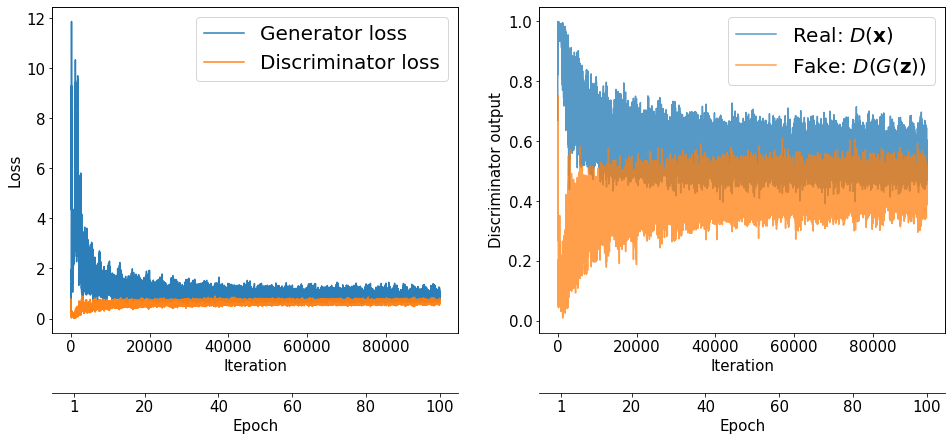

In [23]:
import itertools


fig = plt.figure(figsize=(16, 6))

## Tworzenie wykresu funkcji straty
ax = fig.add_subplot(1, 2, 1)
g_losses = [item[0] for item in itertools.chain(*all_losses)]
d_losses = [item[1]/2.0 for item in itertools.chain(*all_losses)]
plt.plot(g_losses, label='F. straty generatora', alpha=0.95)
plt.plot(d_losses, label='F. straty dyskryminatora', alpha=0.95)
plt.legend(fontsize=20)
ax.set_xlabel('Iteracja', size=15)
ax.set_ylabel('Funkcja straty', size=15)

epochs = np.arange(1, 101)
epoch2iter = lambda e: e*len(all_losses[-1])
epoch_ticks = [1, 20, 40, 60, 80, 100]
newpos = [epoch2iter(e) for e in epoch_ticks]
ax2 = ax.twiny()
ax2.set_xticks(newpos)
ax2.set_xticklabels(epoch_ticks)
ax2.xaxis.set_ticks_position('bottom')
ax2.xaxis.set_label_position('bottom')
ax2.spines['bottom'].set_position(('outward', 60))
ax2.set_xlabel('Epoka', size=15)
ax2.set_xlim(ax.get_xlim())
ax.tick_params(axis='both', which='major', labelsize=15)
ax2.tick_params(axis='both', which='major', labelsize=15)

## Tworzenie wykresu wyników dyskryminatora
ax = fig.add_subplot(1, 2, 2)
d_vals_real = [item[0] for item in itertools.chain(*all_d_vals)]
d_vals_fake = [item[1] for item in itertools.chain(*all_d_vals)]
plt.plot(d_vals_real, alpha=0.75, label=r'Rzeczywiste: $D(\mathbf{x})$')
plt.plot(d_vals_fake, alpha=0.75, label=r'Imitacje: $D(G(\mathbf{z}))$')
plt.legend(fontsize=20)
ax.set_xlabel('Iteracja', size=15)
ax.set_ylabel('Wynik dyskryminatora', size=15)

ax2 = ax.twiny()
ax2.set_xticks(newpos)
ax2.set_xticklabels(epoch_ticks)
ax2.xaxis.set_ticks_position('bottom')
ax2.xaxis.set_label_position('bottom')
ax2.spines['bottom'].set_position(('outward', 60))
ax2.set_xlabel('Epoka', size=15)
ax2.set_xlim(ax.get_xlim())
ax.tick_params(axis='both', which='major', labelsize=15)
ax2.tick_params(axis='both', which='major', labelsize=15)


#plt.savefig('rysunki/r17-gan-krzywa-uczenia.pdf')
plt.show()

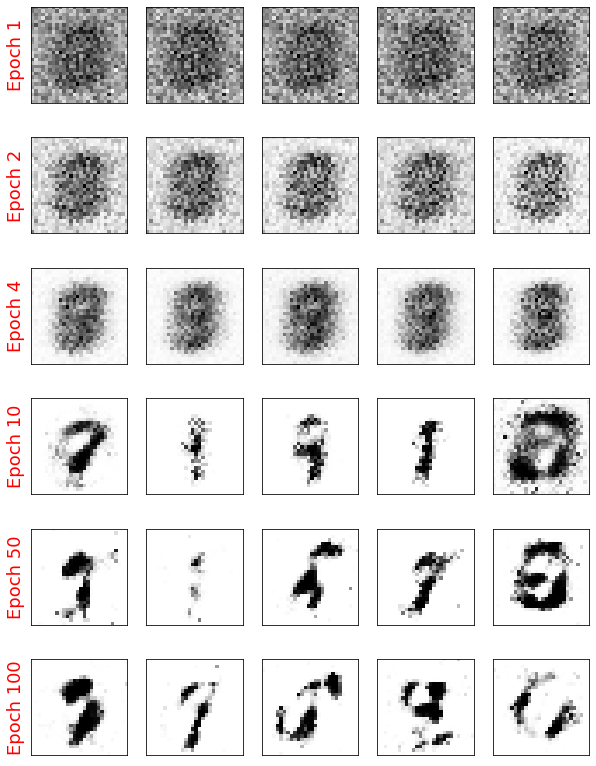

In [24]:
selected_epochs = [1, 2, 4, 10, 50, 100]
fig = plt.figure(figsize=(10, 14))
for i,e in enumerate(selected_epochs):
    for j in range(5):
        ax = fig.add_subplot(6, 5, i*5+j+1)
        ax.set_xticks([])
        ax.set_yticks([])
        if j == 0:
            ax.text(
                -0.06, 0.5, 'Epoka {}'.format(e),
                rotation=90, size=18, color='red',
                horizontalalignment='right',
                verticalalignment='center', 
                transform=ax.transAxes)
        
        image = epoch_samples[e-1][j]
        ax.imshow(image, cmap='gray_r')
    
#plt.savefig('rysunki/r17-standardowa-gan-proby.pdf')
plt.show()

<br>
<br>

----



Czytelnicy mogą zignorować poniższą komórkę.


In [25]:
! python ../.convert_notebook_to_script.py --input r17_cz1.ipynb --output r17_cz1.py

[NbConvertApp] Converting notebook ch17_part1.ipynb to script
[NbConvertApp] Writing 13583 bytes to ch17_part1.py
